In [12]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit.providers.aer import StatevectorSimulator
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from matplotlib import pyplot as plt
from time import process_time
import numpy as np
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit.algorithms.optimizers import SPSA,COBYLA, SLSQP
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE
from qiskit_nature.runtime import VQEClient
import pickle

In [41]:
def model_builder(atom, distance, backend=None, optimizer_name=None):
    t1_start = process_time() 
    molecule = Molecule(
    # coordinates are given in Angstrom
        geometry=[
            [atom, [0.0, 0.0, 0.0]],
            ["H", [0.0, 0.0, distance]],
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )
    
    properties = driver.run()
    
    particle_number = properties.get_property(ParticleNumber)
    
    # Active space transform
    
    if atom == "H":
        num_orbital = 2
        num_qubit   = 2
    elif atom == "Li":
        num_orbital = 3
        num_qubit   = 4
    else:
        pass
    active_space_trafo = ActiveSpaceTransformer(
                         num_electrons=particle_number.num_particles, num_molecular_orbitals=num_orbital
                         )
    # get hamiltonian
    es_problem = ElectronicStructureProblem(driver, transformers=[active_space_trafo])
    second_q_op = es_problem.second_q_ops()
    
    # convert hamiltonian to qubit operator -> use Parity Mapper -> Reduce needed qubit from 4 to 2
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    
    # Solver [Exact]
    if backend == "numpy_eigen_solver":
        solver = NumPyMinimumEigensolver()
    else:
        # Initialization
        ansatz = EfficientSU2(num_qubits=num_qubit, reps=1, entanglement="linear", insert_barriers=True)
        np.random.seed(2)  # fix seed for reproducibility
        initial_point = np.random.random(ansatz.num_parameters)
        
        # Set optimizer
        if optimizer_name == "SPSA":
            optimizer = SPSA(maxiter=200)
        elif optimizer_name == "COBYLA":
            optimizer = COBYLA(maxiter=500, tol=0.0001)
        else:
            optimizer = optimizer = SLSQP(maxiter=5)
            
        # Real device
        if backend == "runtime":
            IBMQ.load_account()
            provider = IBMQ.get_provider(hub='ibm-q')
            backend = provider.get_backend("ibmq_lima")  # select a backend that supports the runtime
            optimizer_runtime = {
                "name": optimizer_name,
                "maxiter": 100,
                "resamplings": {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
            }

            solver = VQEClient(
                ansatz=ansatz,
                optimizer=optimizer_runtime,
                initial_point=initial_point,
                provider=provider,
                backend=backend,
                shots=1024,
                measurement_error_mitigation=True,
            ) 

        else:
            # State vector simulation
            if backend == "aer_simulator_statevector":
                Quantum_instance = QuantumInstance(backend=Aer.get_backend(backend))
            # Noise model simulation
            else:
                Quantum_instance=QasmSimulatorPy()
    
            solver = VQE(
                ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=Quantum_instance,
                )

    
    #Solving problem 
    ground_state_solver = GroundStateEigensolver(qubit_converter, solver)
    res = ground_state_solver.solve(es_problem)
    
    # Output
    t1_stop = process_time()

    return np.real(res.eigenenergies + res.nuclear_repulsion_energy)[0], t1_stop-t1_start

In [42]:
distances = np.arange(0.5, 1.8, 0.2)
backend_list = ["numpy_eigen_solver","aer_simulator_statevector","qasm_simulator"]
optimizers = ["SPSA","COBYLA"]
d = dict()
for back in backend_list:
    for op in optimizers:
        print(back," optimizer: ", op)
        d[back+op] = []
        d[back+op+"_time"] = []
        for distance in distances:
            energy, runtime = model_builder("Li",distance, back, op)
            d[back+op].append(energy)
            d[back+op+"_time"].append(runtime)
            print("dist: ",distance,"energy: ", energy, "take time: ", runtime)

numpy_eigen_solver  optimizer:  SPSA
dist:  0.5 energy:  -7.029087312665569 take time:  38.55905839499974
dist:  0.7 energy:  -7.486151969490381 take time:  35.745972628003074
dist:  0.8999999999999999 energy:  -7.705948142268065 take time:  32.232714593999845
dist:  1.0999999999999999 energy:  -7.808956692531726 take time:  35.38939710100021
dist:  1.2999999999999998 energy:  -7.852202267396665 take time:  29.776706263997767
dist:  1.4999999999999998 energy:  -7.863664119201298 take time:  35.55841028299983
dist:  1.6999999999999997 energy:  -7.857550516688656 take time:  32.90679643399926
numpy_eigen_solver  optimizer:  COBYLA
dist:  0.5 energy:  -7.029087312665544 take time:  36.73835918199984
dist:  0.7 energy:  -7.486151969490363 take time:  33.06134218999796
dist:  0.8999999999999999 energy:  -7.705948142268062 take time:  31.395297996001318
dist:  1.0999999999999999 energy:  -7.808956692531716 take time:  34.51091829699726
dist:  1.2999999999999998 energy:  -7.852202267396644 ta

In [43]:
with open('LiH_sim_iter.pickle', 'wb') as f:
    pickle.dump(d, f)

In [10]:
distances = np.arange(0.5, 2.0, 0.2)
backend_list = ["runtime"]
optimizers = ["SPSA"]
d_real = dict()
for back in backend_list:
    for op in optimizers:
        print(back," optimizer: ", op)
        d_real[back] = []
        d_real[back+"_time"] = []
        for distance in distances:
            energy, runtime = model_builder("Li",distance, back, op)
            d_real[back].append(energy)
            d_real[back+"_time"].append(runtime)
            print("dist: ",distance,"energy: ", energy, "take time: ", runtime)
with open('LiH_QuantumComputer.pickle', 'wb') as f:
    pickle.dump(d_real, f)

runtime  optimizer:  SPSA


ibmqfactory.load_account:WARNING:2022-06-08 07:40:17,102: Credentials are already in use. The existing account in the session will be replaced.


dist:  2.1 energy:  -7.597126250947364 take time:  39.2972068680001


ibmqfactory.load_account:WARNING:2022-06-08 08:33:12,926: Credentials are already in use. The existing account in the session will be replaced.


dist:  2.3000000000000003 energy:  -7.4225300007257555 take time:  36.42758821900043


ibmqfactory.load_account:WARNING:2022-06-08 09:25:13,448: Credentials are already in use. The existing account in the session will be replaced.


KeyboardInterrupt: 

In [47]:
with open('LiH_sim_iter.pickle', 'rb') as f:
    d = pickle.load(f)
d_real["runtime"] = [-6.5304,-6.3521,-6.807,-7.423,-7.457,-7.007,-6.882]
d_real["runtime_time"] = [48.422,45.821,41.151,46.172,45.2,46.441,46.953]

In [45]:
distances = np.arange(0.5, 1.8, 0.2)
distances_real = np.arange(0.5, 1.8, 0.2)
def bond_length(d_list,e_list):
    d = d_list[0]
    e = e_list[0]
    i = 1
    while i < len(d_list):
        if(e_list[i]<e):
            e = e_list[i]
            d = d_list[i]
        i+=1
    return d
def plot(mini,useQC=False):
    plt.plot(distances, d["numpy_eigen_solver"+mini][:], label="Exact Energy")
    plt.plot(distances, d["aer_simulator_statevector"+mini][:], label="VQE Energy (state vector)")
    plt.plot(distances, d["qasm_simulator"+mini][:], label="VQE Energy (noise model)")
    if useQC:
        plt.plot(distances_real, d_real["runtime"], label="Quantum computer")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy(Hartree)')
    plt.legend()
    plt.show()
def measure_length(mini, useQC=False):
    print("exact: ", bond_length(distances,d["numpy_eigen_solver"+mini]), " Angstrom")
    print("VQE(state vector): ", bond_length(distances,d["aer_simulator_statevector"+mini]), " Angstrom")
    print("VQE(noise model): ", bond_length(distances,d["qasm_simulator"+mini]), " Angstrom")
    if useQC:
        print("QC: ", bond_length(distances_real,d_real["runtime"]), " Angstrom")    
def average_time(mini, useQC=False):
    print("exact: ",np.average(d["numpy_eigen_solver"+mini+"_time"])," s")
    print("VQE(state vector): ", np.average(d["aer_simulator_statevector"+mini+"_time"]), " s")
    print("VQE(noise model): ", np.average(d["qasm_simulator"+mini+"_time"]), " s")
    if useQC:
        print("QC: ", np.average(d_real["runtime_time"]), " s")     

SPSA


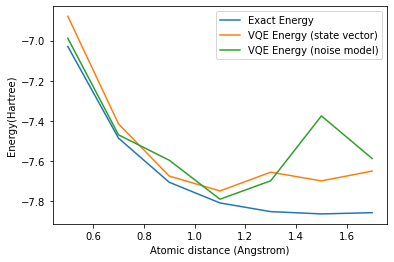

exact:  1.4999999999999998  Angstrom
VQE(state vector):  1.0999999999999999  Angstrom
VQE(noise model):  1.0999999999999999  Angstrom
exact:  34.309865099857106  s
VQE(state vector):  34.829764138570944  s
VQE(noise model):  210.6730465191426  s
----------------
COBYLA


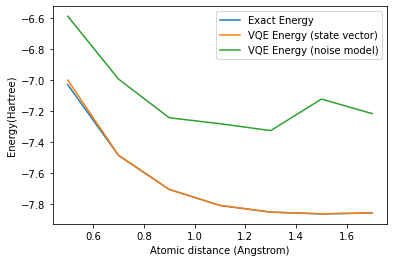

exact:  1.4999999999999998  Angstrom
VQE(state vector):  1.4999999999999998  Angstrom
VQE(noise model):  1.2999999999999998  Angstrom
exact:  33.165225746142305  s
VQE(state vector):  36.25571512542904  s
VQE(noise model):  97.45905245528567  s
----------------


In [48]:
optimizers = ["SPSA","COBYLA"]
for op in optimizers:
    print(op)
    useQC = False
    if op=="SPSA":
        useQC = False
    plot(op,useQC)
    measure_length(op,useQC)
    average_time(op,useQC)
    print("----------------")